In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
! kaggle datasets download -d ashfakyeafi/cat-dog-images-for-classification

Dataset URL: https://www.kaggle.com/datasets/ashfakyeafi/cat-dog-images-for-classification
License(s): CC0-1.0
100% 544M/545M [00:25<00:00, 25.0MB/s]
100% 545M/545M [00:25<00:00, 22.8MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cat-dog-images-for-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
from keras import Sequential, regularizers
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout


In [5]:
df = pd.read_csv('/content/cat_dog.csv')

In [6]:
df.head()

,image,labels
0,dog.11289.jpg,1
1,cat.10836.jpg,0
2,cat.7970.jpg,0
3,cat.2212.jpg,0
4,dog.2653.jpg,1


In [7]:
df.shape

(25000, 2)

In [8]:
df['labels'].value_counts()

,count
labels,
1,12500
0,12500


No Imbalance in the data

In [9]:
#Creating a list of image file paths and labels
image_paths = ['/content/cat_dog/' + fname for fname in df['image']]
labels = df['labels'].values

#Defing a function to load and preprocess images
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = image / 255.0  # Normalize pixel values
    return image, label

#Create a tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(32)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [10]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [11]:
from sklearn.model_selection import train_test_split
   # Calculate the split sizes based on the original dataset size
dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.8 * dataset_size)  # 80% for training
test_size = int(0.2 * dataset_size)   # 20% for testing

   # Create train and test datasets using take and skip
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

In [12]:
#creating a CNN model

model = Sequential()

model.add(Conv2D(8,kernel_size=(3,3),kernel_regularizer=regularizers.l2(0.01),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(16,kernel_size=(3,3),kernel_regularizer=regularizers.l2(0.01),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(32,kernel_size=(3,3),kernel_regularizer=regularizers.l2(0.01),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),kernel_regularizer=regularizers.l2(0.01),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),kernel_regularizer=regularizers.l2(0.01),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(256,kernel_size=(3,3),kernel_regularizer=regularizers.l2(0.01),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 8)         │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 60, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 537,137 (2.05 MB)

 Trainable params: 536,129 (2.05 MB)

 Non-trainable params: 1,008 (3.94 KB)

In [14]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

In [16]:
history = model.fit(train_dataset,epochs=25,validation_data=test_dataset,callbacks=[early_stopping])

Epoch 1/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 112ms/step - accuracy: 0.6323 - loss: 2.8214 - val_accuracy: 0.5944 - val_loss: 1.0463
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 65s 104ms/step - accuracy: 0.7473 - loss: 0.8409 - val_accuracy: 0.6946 - val_loss: 0.9008
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 120ms/step - accuracy: 0.8108 - loss: 0.7328 - val_accuracy: 0.8112 - val_loss: 0.7764
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 120ms/step - accuracy: 0.8521 - loss: 0.6824 - val_accuracy: 0.7596 - val_loss: 0.8323
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 105ms/step - accuracy: 0.8704 - loss: 0.6348 - val_accuracy: 0.7822 - val_loss: 0.7622
Epoch 6/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 105ms/step - accuracy: 0.8794 - loss: 0.6030 - val_accuracy: 0.8610 - val_loss: 0.6301
Epoch 7/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 106ms/step - accuracy: 0.8883 - loss: 0.5720 - val_accuracy: 0.7800 - val_loss: 0.8098
Epoch 8/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 65s 105ms/step - accuracy: 0.8917 - loss: 0

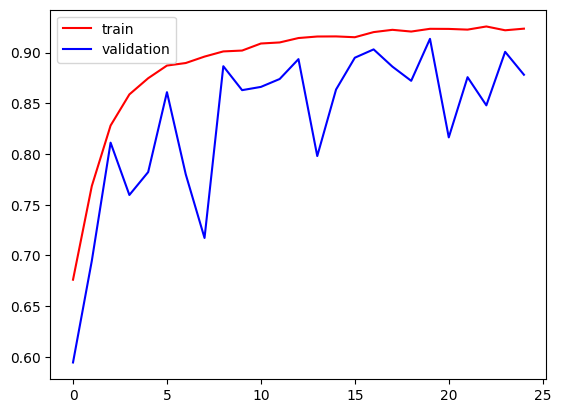

In [22]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

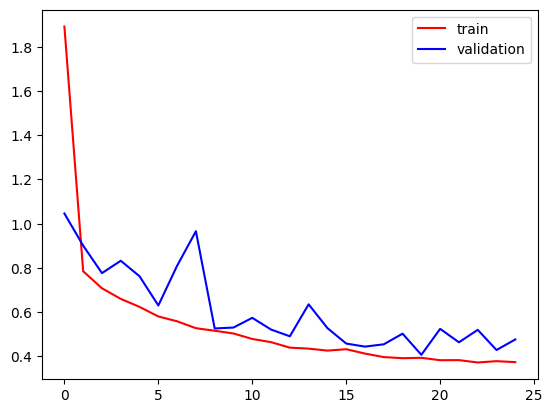

In [23]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [24]:
import cv2

In [25]:
test_image1 = cv2.imread('/content/animal1.jpg')

In [26]:
test_image2 = cv2.imread('/content/animal2.jpg')

array([[[149,  97, 215],
        [149,  97, 215],
        [147,  97, 215],
        ...,
        [129,  90, 175],
        [130,  91, 176],
        [131,  92, 177]],

       [[149,  97, 215],
        [149,  97, 215],
        [147,  97, 215],
        ...,
        [128,  89, 174],
        [129,  90, 175],
        [130,  91, 176]],

       [[149,  96, 217],
        [149,  96, 217],
        [149,  97, 215],
        ...,
        [130,  91, 176],
        [131,  92, 178],
        [132,  93, 179]],

       ...,

       [[171, 141, 216],
        [171, 141, 216],
        [171, 141, 216],
        ...,
        [124,  92, 171],
        [124,  92, 171],
        [124,  92, 171]],

       [[172, 141, 216],
        [172, 141, 216],
        [172, 141, 216],
        ...,
        [124,  92, 171],
        [124,  92, 171],
        [124,  92, 171]],

       [[172, 141, 216],
        [172, 141, 216],
        [172, 141, 216],
        ...,
        [124,  92, 171],
        [124,  92, 171],
        [124,  92, 171]]], dtype=uint8)
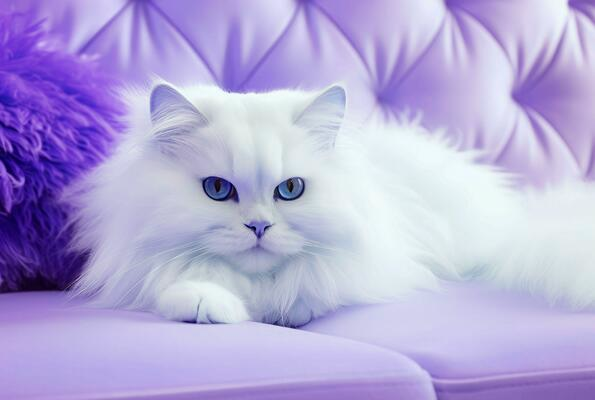

In [27]:
test_image1

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
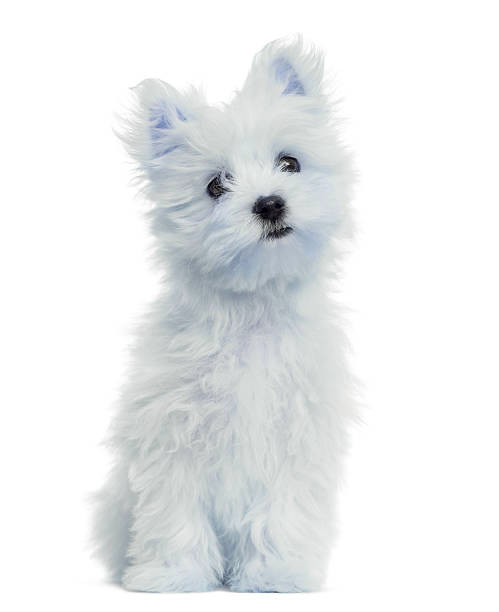

In [28]:
test_image2

In [29]:
print(test_image1.shape)
print(test_image2.shape)

(400, 595, 3)
(612, 499, 3)


In [30]:
test_image1 = cv2.resize(test_image1,(256,256))
test_image2 = cv2.resize(test_image2,(256,256))

In [31]:
test_image1 = test_image1.reshape(1,256,256,3)
test_image2 = test_image2.reshape(1,256,256,3)

In [32]:
model.predict(test_image1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0.]], dtype=float32)

In [33]:
model.predict(test_image2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[1.]], dtype=float32)